# File and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


filepath=r'data/df_gira_agg_2h_pre_proc.csv'

file_tag = "Gira Bike"


# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [5]:
# test_data=True
test_data=False

df=pd.read_csv(filepath, sep=';', decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5421 entries, 01/01/2022 12:00 to 31/03/2023 22:00
Data columns (total 12 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   temperature_2m                                               5421 non-null   float64
 1   rain_mm                                                      5421 non-null   float64
 2   wmo_weather_code                                             5421 non-null   int64  
 3   wind_speed_10m                                               5421 non-null   float64
 4   is_holiday_lisbon                                            5421 non-null   float64
 5   target_station_status                                        5343 non-null   float64
 6   target_station_load_rate                                     5343 non-null   float64
 7   station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima

# Missing values Analysis

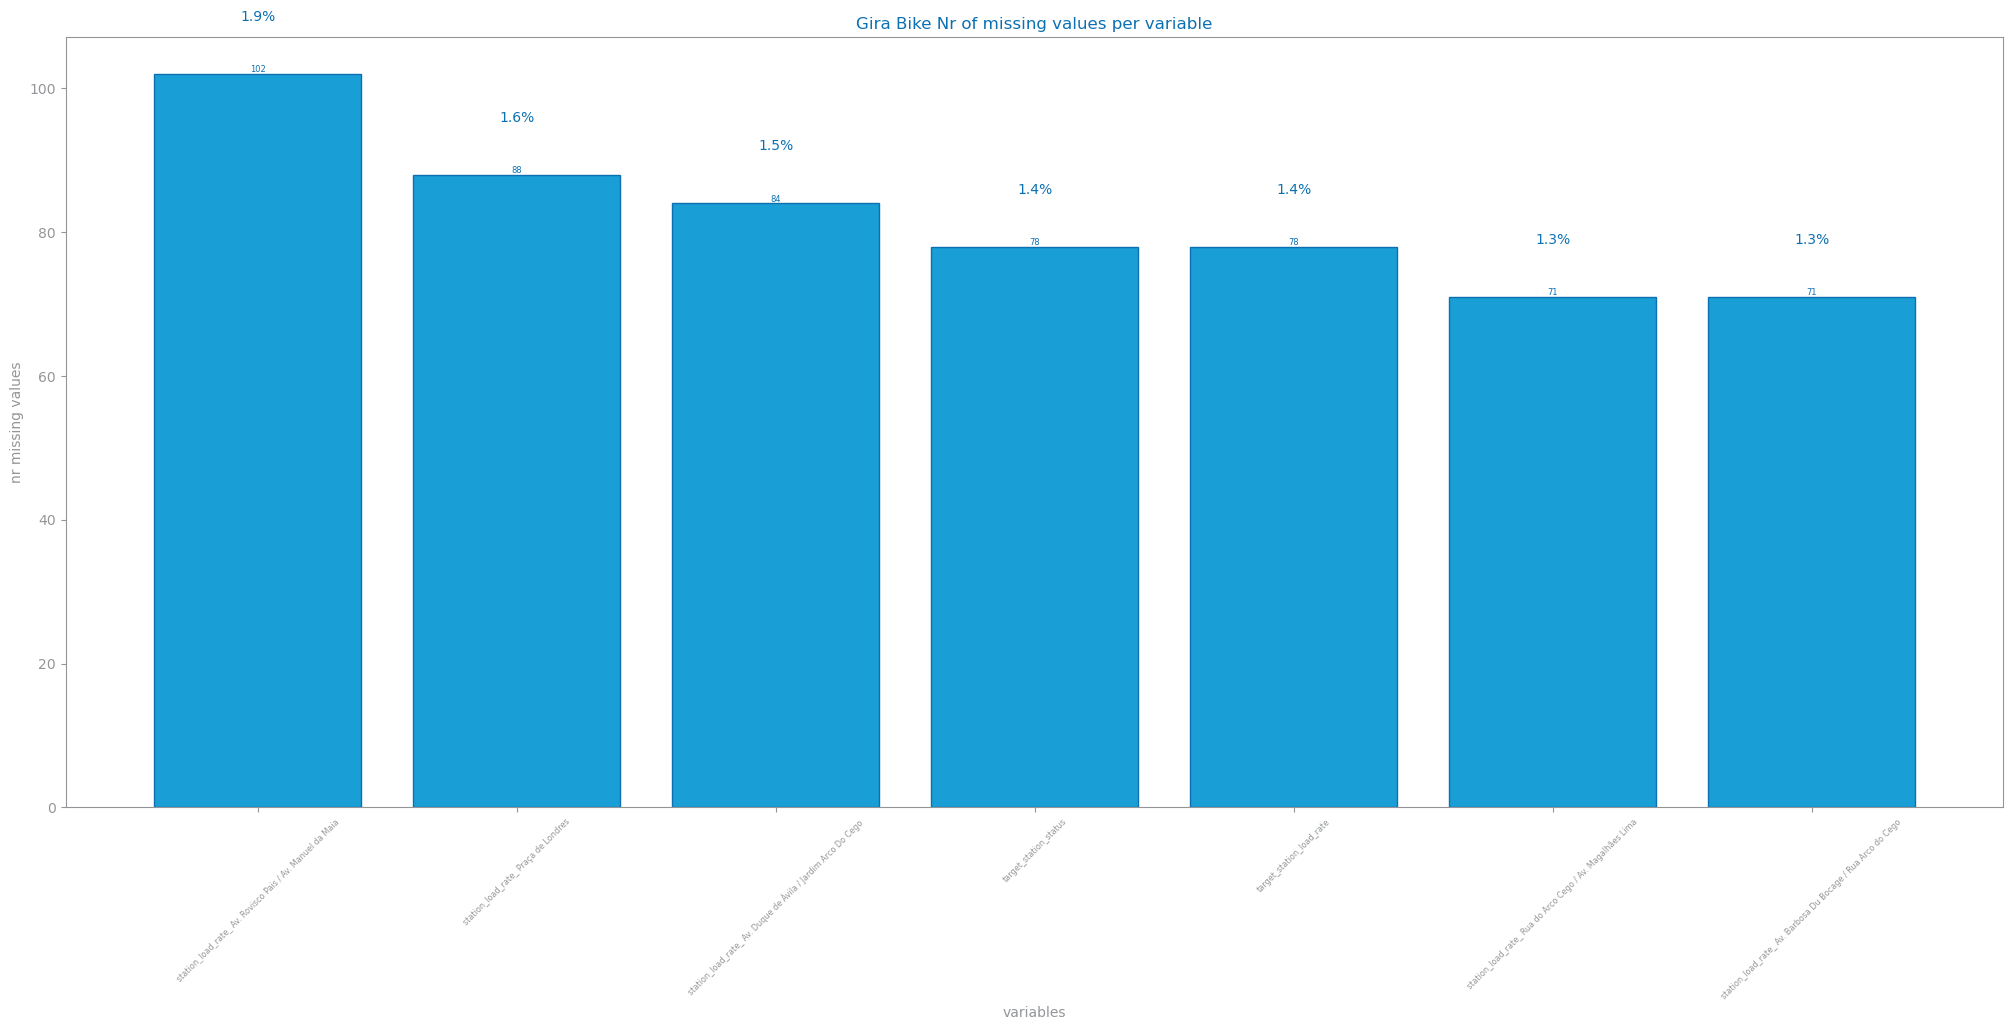

In [6]:

from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

mv: dict[str, int] = {}
total_rows = len(df)

for var in df.columns:
    nr: int = df[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

figure(figsize=(25, 10)) #(largura,altura) 

plot_bar_chart(
    variables,
    missing_values,
    title=f"{file_tag} Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

savefig(f"images/{file_tag}_mv.png")
show()

In [7]:
df_mv = df[df.isna().any(axis=1)]

display(df_mv.head())
display(df_mv.shape)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 22:00,13.8,0.0,3,8.8,1.0,1.0,4.0,33.3,NaN,30.0,NaN,13.3
02/01/2022 06:00,14.0,0.0,3,3.1,0.0,1.0,24.0,NaN,30.8,30.0,21.7,30.0
03/01/2022 08:00,12.4,0.0,3,4.0,0.0,1.0,60.0,NaN,65.4,60.0,13.0,33.3
04/01/2022 14:00,13.8,0.0,1,22.2,0.0,1.0,48.0,78.6,68.6,NaN,23.9,75.0
05/01/2022 14:00,15.0,0.0,3,22.0,0.0,1.0,50.7,NaN,28.9,NaN,4.3,75.0


(443, 12)

## Missing values Treatment
- We can apply several missing values treatment techniques
    - KNN
    - ARIMA
    - Interpolate: The linear interpolation (interpolate) method was used to fill in missing values (NaN) in the dataset. This method estimates missing values by assuming a linear variation between the previous and next known data points within the same column. In other words, for each missing value, the algorithm calculates an intermediate value by drawing a straight line between the nearest available data points.
    - Fill na's with average of previous and next point in time
- In this step, we will not evaluate the results of transformation and we will aply the treamtment tecnique:
    - Fill na's with average of previous and next point in time

### MV 1 Treat - Interpolate

In [8]:
df.head()

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,17.4,0.0,3,5.5,1.0,1.0,34.7,28.6,47.4,60.0,12.3,16.7
01/01/2022 14:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.3,37.2,68.0,13.0,13.3
01/01/2022 16:00,16.7,0.0,2,6.2,1.0,1.0,8.0,30.4,8.6,43.6,4.3,7.5
01/01/2022 18:00,13.9,0.0,3,7.6,1.0,1.0,4.0,20.0,25.6,15.0,0.0,10.0
01/01/2022 20:00,13.8,0.0,3,8.8,1.0,1.0,4.0,21.4,35.9,27.5,15.2,10.0


#### Interpolate

In [9]:
# Preencher valores NaN usando interpolação linear
df_filled_interpolate = df.interpolate(method='linear', axis=0).round(1)#axis= 0 - a cada linha

# Verificar o resultado
display(df_filled_interpolate.head(10))

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,17.4,0.0,3,5.5,1.0,1.0,34.7,28.6,47.4,60.0,12.3,16.7
01/01/2022 14:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.3,37.2,68.0,13.0,13.3
01/01/2022 16:00,16.7,0.0,2,6.2,1.0,1.0,8.0,30.4,8.6,43.6,4.3,7.5
01/01/2022 18:00,13.9,0.0,3,7.6,1.0,1.0,4.0,20.0,25.6,15.0,0.0,10.0
01/01/2022 20:00,13.8,0.0,3,8.8,1.0,1.0,4.0,21.4,35.9,27.5,15.2,10.0
01/01/2022 22:00,13.8,0.0,3,8.8,1.0,1.0,4.0,33.3,33.8,30.0,18.4,13.3
02/01/2022 00:00,13.0,0.0,3,7.6,0.0,1.0,10.7,28.6,31.8,30.0,21.7,12.5
02/01/2022 02:00,13.1,0.0,3,7.4,0.0,1.0,24.0,21.4,30.8,30.0,21.7,35.0
02/01/2022 04:00,14.2,0.0,3,5.1,0.0,1.0,24.0,39.2,30.8,30.0,21.7,30.0


In [10]:
df.head(10)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,17.4,0.0,3,5.5,1.0,1.0,34.7,28.6,47.4,60.0,12.3,16.7
01/01/2022 14:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.3,37.2,68.0,13.0,13.3
01/01/2022 16:00,16.7,0.0,2,6.2,1.0,1.0,8.0,30.4,8.6,43.6,4.3,7.5
01/01/2022 18:00,13.9,0.0,3,7.6,1.0,1.0,4.0,20.0,25.6,15.0,0.0,10.0
01/01/2022 20:00,13.8,0.0,3,8.8,1.0,1.0,4.0,21.4,35.9,27.5,15.2,10.0
01/01/2022 22:00,13.8,0.0,3,8.8,1.0,1.0,4.0,33.3,NaN,30.0,NaN,13.3
02/01/2022 00:00,13.0,0.0,3,7.6,0.0,1.0,10.7,28.6,31.8,30.0,21.7,12.5
02/01/2022 02:00,13.1,0.0,3,7.4,0.0,1.0,24.0,21.4,30.8,30.0,21.7,35.0
02/01/2022 04:00,14.2,0.0,3,5.1,0.0,1.0,24.0,39.2,30.8,30.0,21.7,30.0


In [11]:
df_mv_treat_1 = df_filled_interpolate[df_filled_interpolate.isna().any(axis=1)]

display(df_mv_treat_1.head())
display(df_mv_treat_1.shape)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,


(0, 12)

In [12]:
display(df_filled_interpolate.head())
display(df_filled_interpolate.shape)

,temperature_2m,rain_mm,wmo_weather_code,wind_speed_10m,is_holiday_lisbon,target_station_status,target_station_load_rate,station_load_rate_ Rua do Arco Cego / Av. Magalhães Lima,station_load_rate_ Av. Rovisco Pais / Av. Manuel da Maia,station_load_rate_ Praça de Londres,station_load_rate_ Av. Duque de Ávila / Jardim Arco Do Cego,station_load_rate_ Av. Barbosa Du Bocage / Rua Arco do Cego
date,,,,,,,,,,,,
01/01/2022 12:00,17.4,0.0,3,5.5,1.0,1.0,34.7,28.6,47.4,60.0,12.3,16.7
01/01/2022 14:00,18.6,0.0,3,5.8,1.0,1.0,20.0,14.3,37.2,68.0,13.0,13.3
01/01/2022 16:00,16.7,0.0,2,6.2,1.0,1.0,8.0,30.4,8.6,43.6,4.3,7.5
01/01/2022 18:00,13.9,0.0,3,7.6,1.0,1.0,4.0,20.0,25.6,15.0,0.0,10.0
01/01/2022 20:00,13.8,0.0,3,8.8,1.0,1.0,4.0,21.4,35.9,27.5,15.2,10.0


(5421, 12)

# save to csv

In [13]:
df = df_filled_interpolate.copy() 
df.reset_index(inplace=True)
    
df.to_csv(f"data/df_gira_agg_2h_mv_input.csv", index=False)